Alteration of simple globally-uniform WCWC experiment to include spatial variability.

Here we use the same linear time series files created from that script, but add a spatial structure file.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob
import copy

In [4]:
# Define inputs and output folders:
JRAin = '/g/data/ik11/inputs/JRA-55/RYF/v1-4/' # Location of RYF JRA55-do input forcing files
Tin = JRAin + 'RYF.tas.1990_1991.nc' # Air temperature forcing file
LRin = JRAin + 'RYF.rlds.1990_1991.nc' # Longwave radiation forcing file

JRAout = '/g/data/e14/rmh561/access-om2/input/RCP/scaling/' # Output location for storing scaling files created by this script

# Temporal scaling files:
Tout = JRAout + 'RYF.tas.1990_1991_scaling.nc' # Air temperature scaling file
LRout = JRAout + 'RYF.rlds.1990_1991_scaling.nc' # Longwave radiation scaling file

# Spatial scaling files:
ToutSP = JRAout + 'RYF.tas.1990_1991_scalingPAC.nc'
LRoutSP = JRAout + 'RYF.rlds.1990_1991_scalingPAC.nc'

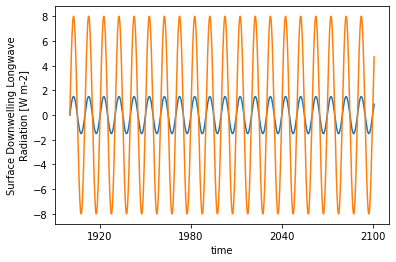

In [4]:
# Create temporal scaling file:

# Define start and end times (based on "experiment" calendar, see https://github.com/COSIMA/access-om2/wiki/Tutorials#Scaling-the-forcing-fields)
tstart = 1900 # start year of window in which scaling will be applied (1900 = initial time of control simulation)
tend = 2100 # end year of window in which scaling will be applied

seconds_in_year = (cftime.DatetimeNoLeap(1901,1,1,0,0,0,0) - cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()

# Define sinusoid properties:
Tamp = 1.5  # degrees C
LRamp = 8   # Wm-2
period = 10 # years
zeroYR = 0  # years

# Extract time series and structure from original files:
Tds_in = xr.open_dataset(Tin)
LRds_in = xr.open_dataset(LRin)

timeRYF = Tds_in.time.values
timeFULL = np.concatenate(np.array([np.array([cftime.DatetimeNoLeap(year,x.month,x.day,x.hour,0,0,0) for x in timeRYF]) for year in np.arange(tstart,tend+1)])).ravel()
timeYR = np.array([(x-cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()/seconds_in_year for x in timeFULL])

# Make sinusoids:
tas_ts = Tamp*np.sin(2*np.pi*(timeYR-zeroYR)/period)
rlds_ts = LRamp*np.sin(2*np.pi*(timeYR-zeroYR)/period)

# Create new Datasets:
tas = xr.DataArray(tas_ts, dims=['time'], coords={'time': timeFULL}, attrs=Tds_in.tas.attrs)
Tds_out = Tds_in.drop_vars('tas').assign_coords({'time':timeFULL})
Tds_out['tas'] = tas
Tds_out.attrs.update({'title': 'Scaling for ' + Tds_out.attrs['title']})


rlds = xr.DataArray(rlds_ts, dims=['time'], coords={'time': timeFULL}, attrs=LRds_in.rlds.attrs)
LRds_out = LRds_in.drop_vars('rlds').assign_coords({'time':timeFULL})
LRds_out['rlds'] = rlds
LRds_out.attrs.update({'title': 'Scaling for ' + LRds_out.attrs['title']})

# Plot as check:
Tds_out.tas.plot()
LRds_out.rlds.plot()

# Convert time back to days since 1900-1-1 (this is clunky... I'm sure there's a better way):
Tds_out = Tds_out.assign_coords({'time':timeYR*seconds_in_year/86400})
LRds_out = LRds_out.assign_coords({'time':timeYR*seconds_in_year/86400})
attrsdic = {
    'long_name':      "time",
    'units':          "days since 1900-01-01",
    'cartesian_axis': "T",
    'calendar_type':  "NOLEAP",
    'calendar':       "NOLEAP"}
Tds_out.time.attrs = attrsdic
LRds_out.time.attrs = attrsdic

# Save back to netcdf:
LRds_out.to_netcdf(LRout)
Tds_out.to_netcdf(Tout)

In [20]:
# Create spatial scaling file:
Tds_out = xr.open_dataset(Tin).isel(time=0)
LRds_out = xr.open_dataset(LRin).isel(time=0)

Tds_out['tas'] = 0.*Tds_out.tas
Tds_out['tas'].sel(lon=slice(100,200)).values += 1.
LRds_out['rlds'] = 0.*LRds_out.rlds
LRds_out['rlds'].sel(lon=slice(100,200)).values += 1.

LRds_out.to_netcdf(LRoutSP)
Tds_out.to_netcdf(ToutSP)

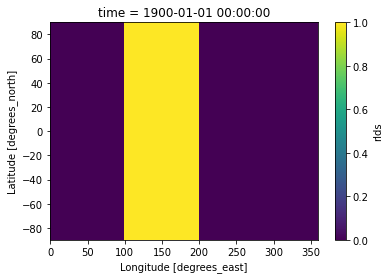

In [19]:
LRds_out.rlds.plot()